In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


2025-07-20 12:15:58.189872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 12:15:58.190455: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 12:15:58.193879: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 12:15:58.203952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753006558.223694   21367 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753006558.22

In [4]:
data = pd.read_csv("data/preprocessed.csv")
m = len(data)
test, cv, train = data.iloc[:round(0.1*m)], data.iloc[round(0.1*m): round(0.2*m)], data.iloc[round(0.2*m):]
x_cols = data.columns.drop(["winner"])
X_test, y_test = test[test["winner"] != 0.5][x_cols].values, test[test["winner"] != 0.5]["winner"].values
X_cv, y_cv = cv[cv["winner"] != 0.5][x_cols].values, cv[cv["winner"] != 0.5]["winner"].values
X_train, y_train = train[x_cols].values, train["winner"].values

In [5]:
scaler = Normalization(axis= -1)
scaler.adapt(X_train)

2025-07-20 12:16:05.373740: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        scaler,
        Dense(units = 2, activation="relu", kernel_regularizer=L2(l2= 0.3)),
        Dense(units = 1, activation="sigmoid")
    ]
)


In [7]:
model.compile(
    loss= BinaryCrossentropy(from_logits= True),
    optimizer= Adam()
)
history= model.fit(
    X_train, y_train,
    validation_data= (X_cv, y_cv),
    epochs = 100,
    verbose= 1,
    callbacks= [
        tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
    ]
)

Epoch 1/100


/home/luka/Documents/Python_projekti/ufc_pred/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4773 - val_loss: 0.8777
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8070 - val_loss: 0.7111
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6805 - val_loss: 0.6831
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6561 - val_loss: 0.6733
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6497 - val_loss: 0.6724
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6420 - val_loss: 0.6694
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6454 - val_loss: 0.6707
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6522 - val_loss: 0.6701
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6481 - val_loss: 0.6696
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6526 - val_loss: 0.6692
Epoch 11/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6429 - val_loss: 0.6710
Epoch 12/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

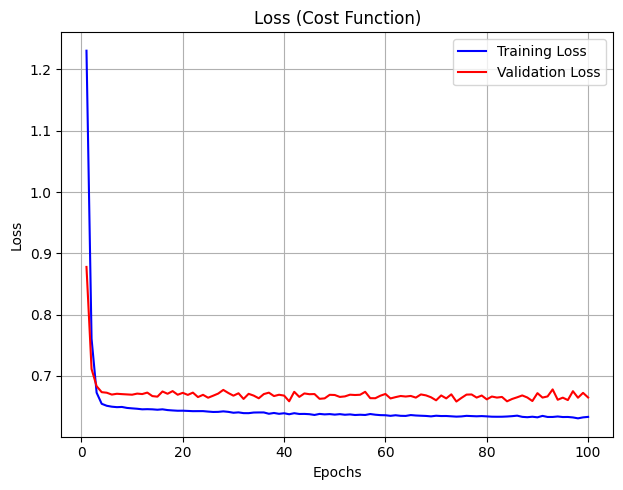

In [8]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss (Cost Function)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Max f1 score = 0.6170886075949367
threshold for max f1 score = 0.6306306306306306
Max acc score = 0.6363636363636364
threshold for max acc score = 0.4804804804804805


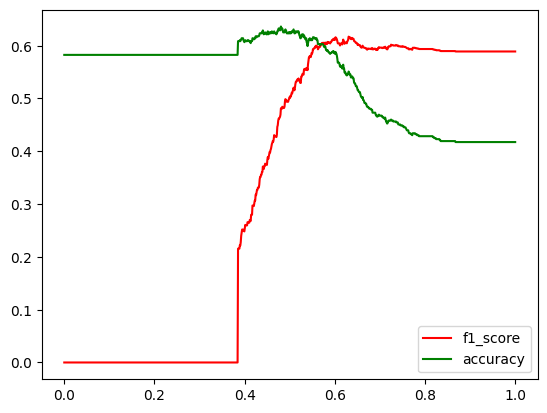

In [9]:
result = model.predict(X_cv)
result=result.flatten()
thresholds = np.linspace(0,1, num=1000)
f1_values = []
acc_values = []
max_f1 = 0
best_thresh_f1 = 0
max_acc = 0
best_thresh_acc = 0

for thresh in thresholds:
    ypred = np.where(result > thresh, 1, 0)
    f1 = f1_score(y_cv, ypred,pos_label= 0)
    acc = accuracy_score(y_cv,ypred)
    if f1 > max_f1:
        max_f1 = f1
        best_thresh_f1 = thresh
    if acc > max_acc:
        max_acc = acc
        best_thresh_acc = thresh
    f1_values.append(f1)
    acc_values.append(acc)

plt.plot(thresholds, np.array(f1_values),color= "r", label= "f1_score")
plt.plot(thresholds, np.array(acc_values),color= "g", label= "accuracy")
plt.legend()

print(f"Max f1 score = {max_f1}")
print(f"threshold for max f1 score = {best_thresh_f1}")
print(f"Max acc score = {max_acc}")
print(f"threshold for max acc score = {best_thresh_acc}")

In [10]:
accuracy_score(y_test, np.where(model.predict(X_test).flatten() > 0.5, 1,0))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.6422018348623854

Epoch 1/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5384
Epoch 2/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7725
Epoch 3/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6795
Epoch 4/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6665
Epoch 5/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6648
Epoch 6/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6615
Epoch 7/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6568
Epoch 8/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6570
Epoch 9/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6531
Epoch 10/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6548
Epoch 11/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6573
Epoch 12/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6484
Epoch 13/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6514
Epoch 14/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6477
Epoch 15/80
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

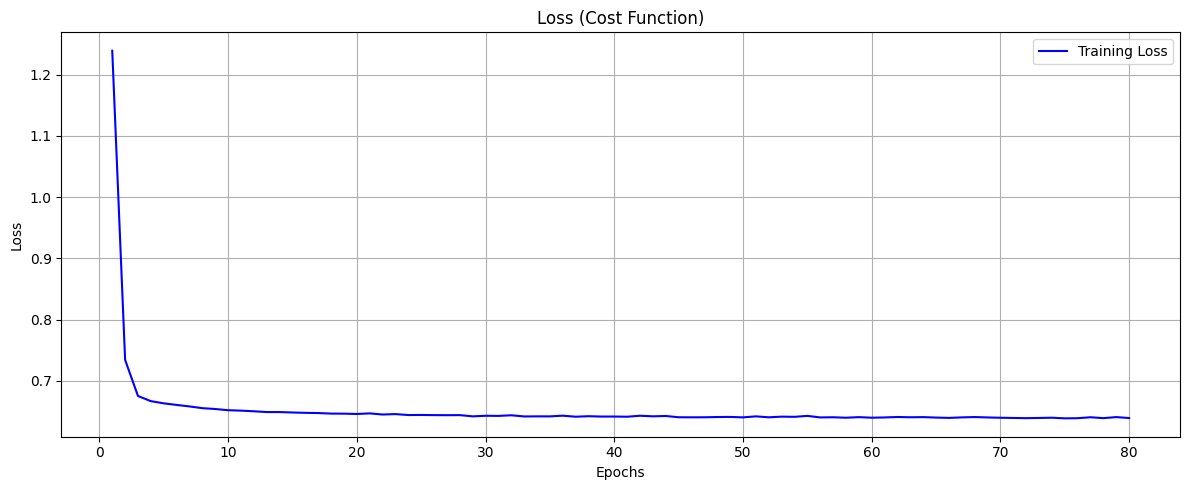

In [12]:
model_to_save = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        scaler,
        Dense(units = 2, activation="relu", kernel_regularizer=L2(l2= 0.3)),
        Dense(units = 1, activation="sigmoid")
    ]
)

model_to_save.compile(
    loss= BinaryCrossentropy(from_logits= True),
    optimizer= Adam()
)
history_save= model_to_save.fit(
    data[data["winner"] != 0.5][x_cols].values, data[data["winner"] != 0.5]["winner"].values,
    epochs = 80,
    verbose= 1
)
train_loss_save = history_save.history['loss']
epochs_save = range(1, len(train_loss_save) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.plot(epochs_save, train_loss_save, 'b-', label='Training Loss')
plt.title('Loss (Cost Function)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
model_to_save.save("models/nn_model.keras")